In [1]:
# Daniel Bandala @ apr 2022
import numpy as np
from datetime import datetime 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# LeNet
LeNet is a convolutional neural network structure proposed by Yann LeCun et al. in 1989. In general, LeNet refers to LeNet-5 and is a simple convolutional neural network. Convolutional neural networks are a kind of feed-forward neural network whose artificial neurons can respond to a part of the surrounding cells in the coverage range and perform well in large-scale image processing. LeNet-5 is a 7 layer Convolutional Neural Network, trained on grayscale images of size 32 x 32 pixels.

<img src="https://miro.medium.com/max/700/1*ueA-rooOaiIo3s2rVVz3Ww.png" width="700" height="220" role="presentation">

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

ROW_IMG = 10
N_ROWS = 5

In [5]:
# training function
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [6]:
# accuracy function
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [7]:
# plot losses values in current training step
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (16, 8))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [8]:
# validation function
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [9]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    return model, optimizer, (train_losses, valid_losses)

## Load MNIST dataset
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

In [10]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms,
                              download=True)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

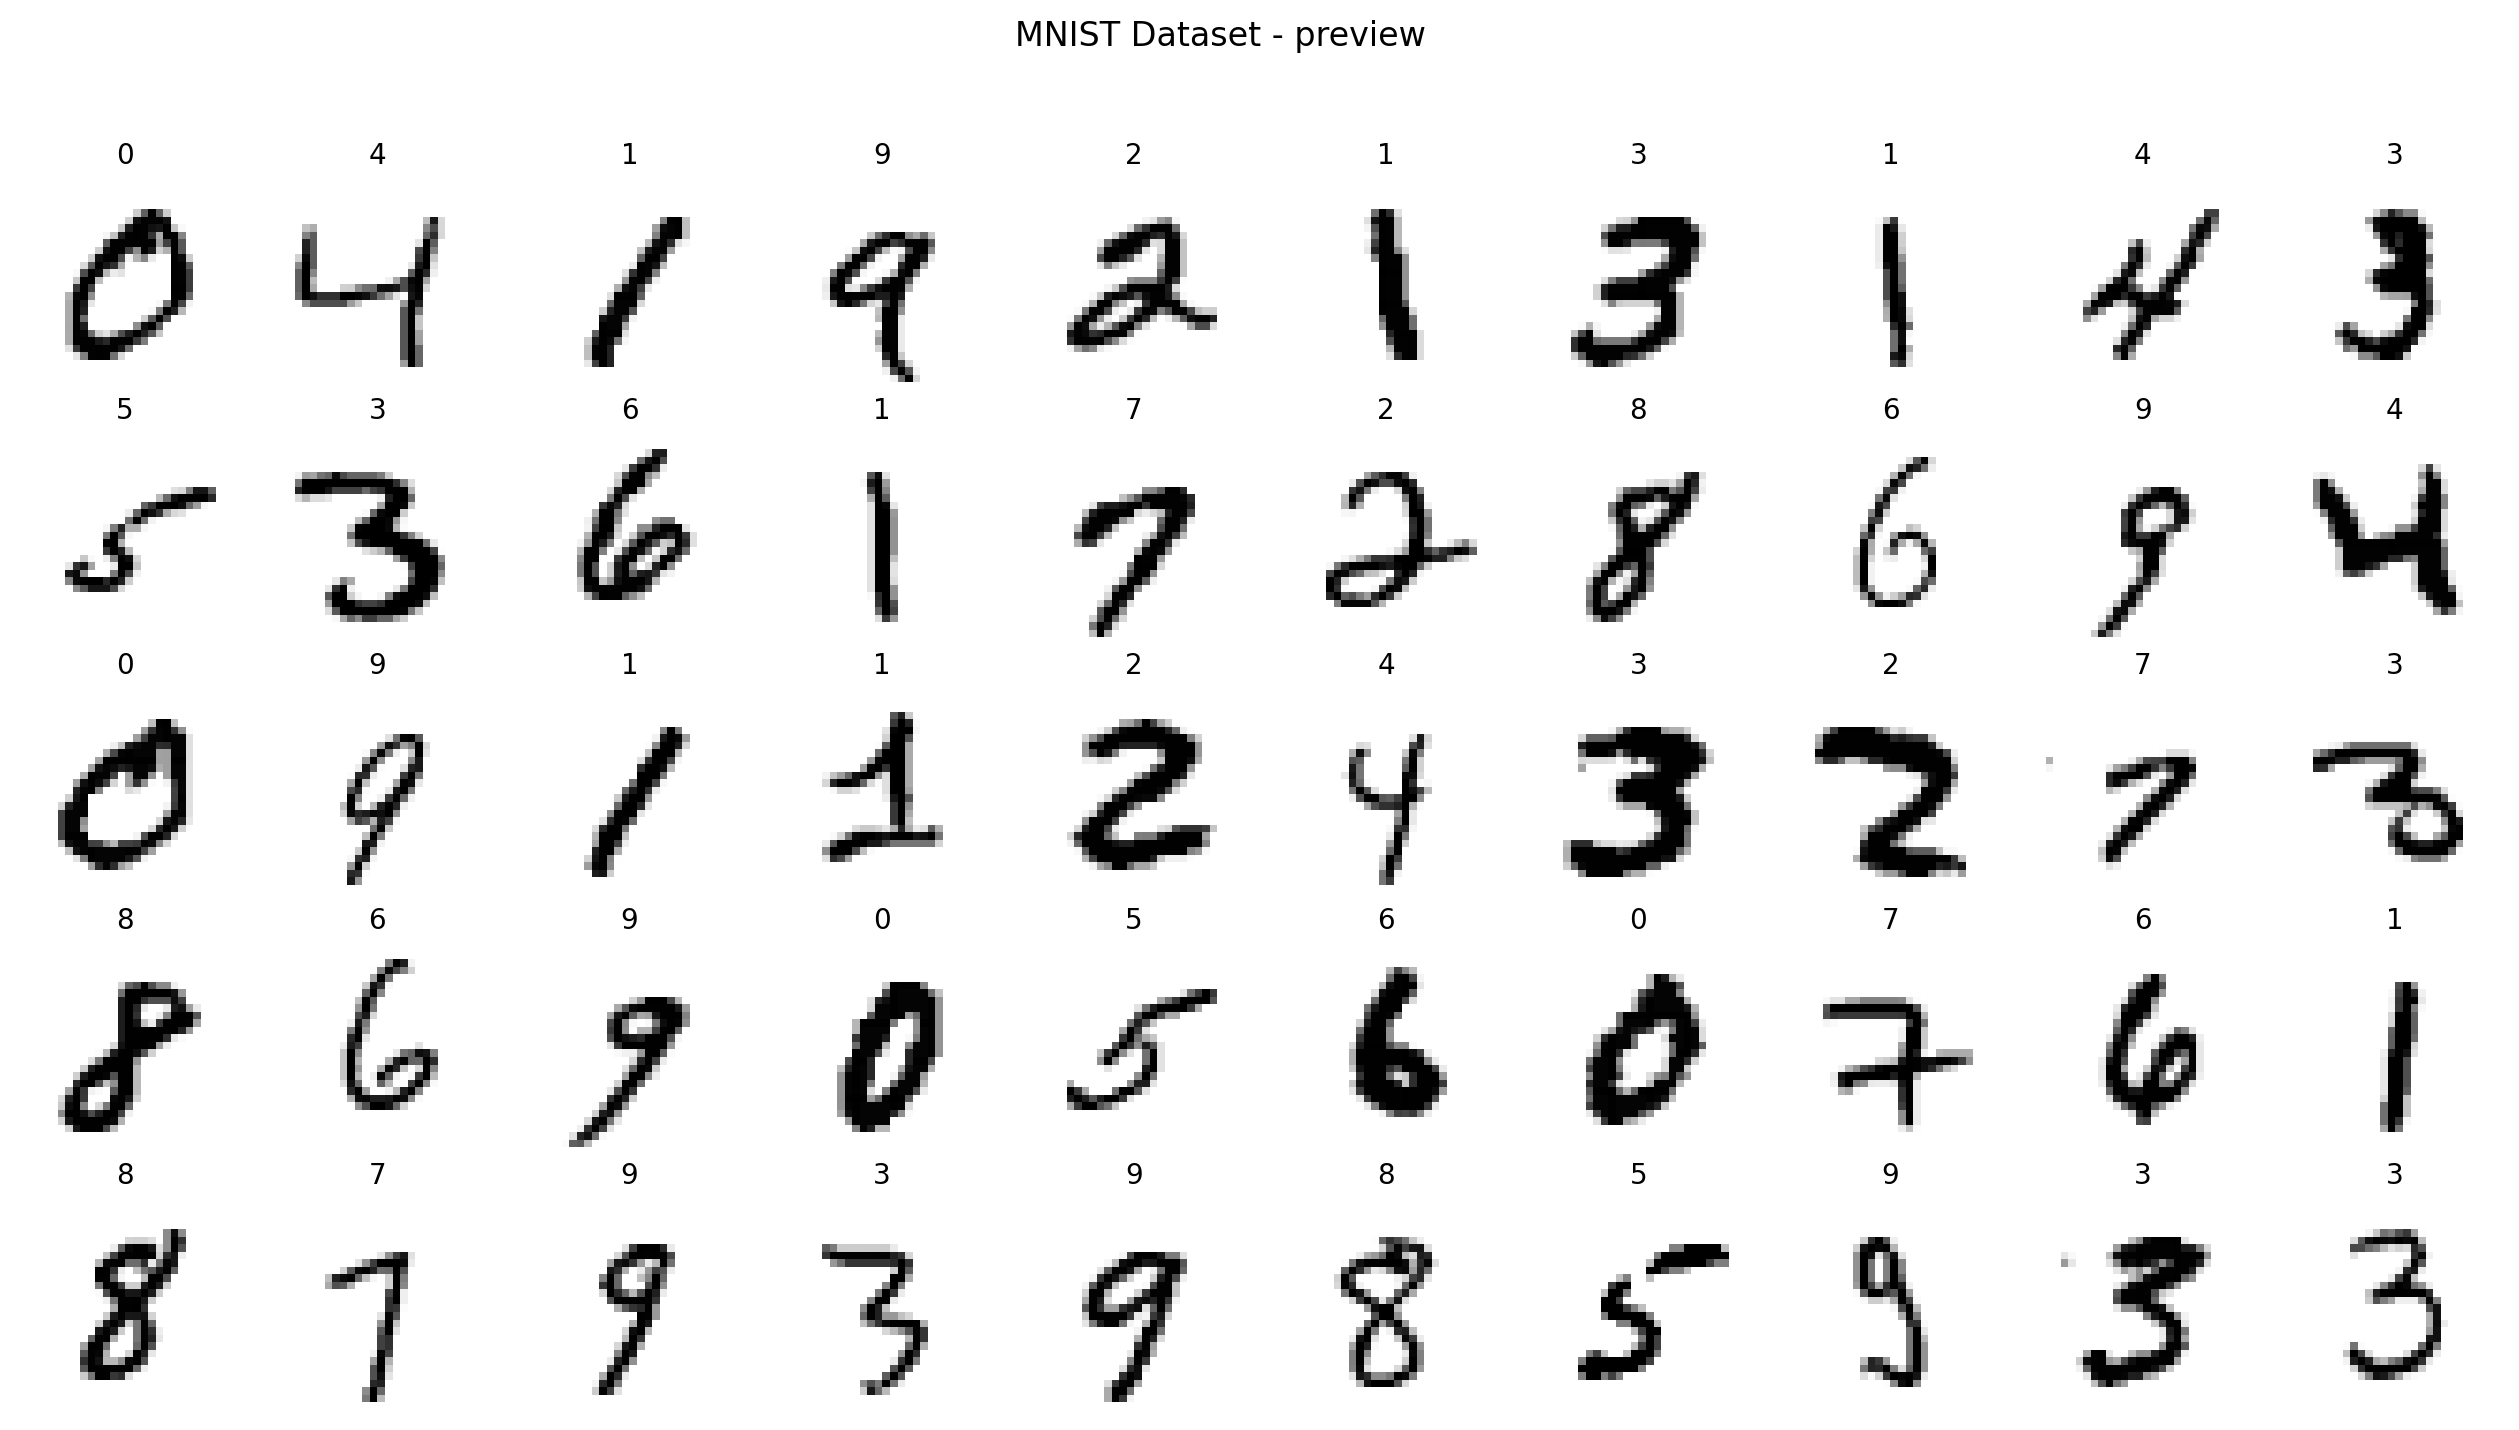

In [26]:
#plotting images
fig = plt.figure(figsize=(16,8))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index],cmap='gray_r')
    plt.title(train_dataset.targets[index].item(), fontsize=10)
fig.suptitle('MNIST Dataset - preview');

## LeNet Model
1. Layer 1 (C1): The first convolutional layer with 6 kernels of size 5×5 and the stride of 1. Given the input size (32×32×1), the output of this layer is of size 28×28×6.
2. Layer 2 (S2): A subsampling/pooling layer with 6 kernels of size 2×2 and the stride of 2. The subsampling layer in the original architecture was a bit more complex than the traditionally used max/average pooling layers. I will quote [1]: “ The four inputs to a unit in S2 are added, then multiplied by a trainable coefficient, and added to a trainable bias. The result is passed through a sigmoidal function.”. As a result of non-overlapping receptive fields, the input to this layer is halved in size (14×14×6).
3. Layer 3 (C3): The second convolutional layer with the same configuration as the first one, however, this time with 16 filters. The output of this layer is 10×10×16.
4. Layer 4 (S4): The second pooling layer. The logic is identical to the previous one, but this time the layer has 16 filters. The output of this layer is of size 5×5×16.
5. Layer 5 (C5): The last convolutional layer with 120 5×5 kernels. Given that the input to this layer is of size 5×5×16 and the kernels are of size 5×5, the output is 1×1×120. As a result, layers S4 and C5 are fully-connected. That is also why in some implementations of LeNet-5 actually use a fully-connected layer instead of the convolutional one as the 5th layer. The reason for keeping this layer as a convolutional one is the fact that if the input to the network is larger than the one used in [1] (the initial input, so 32×32 in this case), this layer will not be a fully-connected one, as the output of each kernel will not be 1×1.
6. Layer 6 (F6): The first fully-connected layer, which takes the input of 120 units and returns 84 units. In the original paper, the authors used a custom activation function — a variant of the tanh activation function. For a thorough explanation, please refer to Appendix A in [1].
7. Layer 7 (F7): The last dense layer, which outputs 10 units. In [1], the authors used Euclidean Radial Basis Function neurons as activation functions for this layer.

In [12]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [13]:
# define LeNet model
model = LeNet5(N_CLASSES).to(DEVICE)
# define training parameteres
torch.manual_seed(RANDOM_SEED)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

11:58:55 --- Epoch: 0	Train loss: 0.2351	Valid loss: 0.0992	Train accuracy: 97.21	Valid accuracy: 97.09
11:59:18 --- Epoch: 1	Train loss: 0.0804	Valid loss: 0.0754	Train accuracy: 98.06	Valid accuracy: 97.53
11:59:42 --- Epoch: 2	Train loss: 0.0564	Valid loss: 0.0515	Train accuracy: 98.92	Valid accuracy: 98.33
12:00:06 --- Epoch: 3	Train loss: 0.0453	Valid loss: 0.0572	Train accuracy: 98.82	Valid accuracy: 98.13
12:00:29 --- Epoch: 4	Train loss: 0.0375	Valid loss: 0.0464	Train accuracy: 99.18	Valid accuracy: 98.51
12:00:53 --- Epoch: 5	Train loss: 0.0321	Valid loss: 0.0472	Train accuracy: 99.21	Valid accuracy: 98.43
12:01:16 --- Epoch: 6	Train loss: 0.0264	Valid loss: 0.0604	Train accuracy: 99.07	Valid accuracy: 98.14
12:01:40 --- Epoch: 7	Train loss: 0.0244	Valid loss: 0.0383	Train accuracy: 99.53	Valid accuracy: 98.76
12:02:03 --- Epoch: 8	Train loss: 0.0180	Valid loss: 0.0497	Train accuracy: 99.50	Valid accuracy: 98.60
12:02:27 --- Epoch: 9	Train loss: 0.0189	Valid loss: 0.0445	Trai

/tmp/ipykernel_12298/3867821247.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


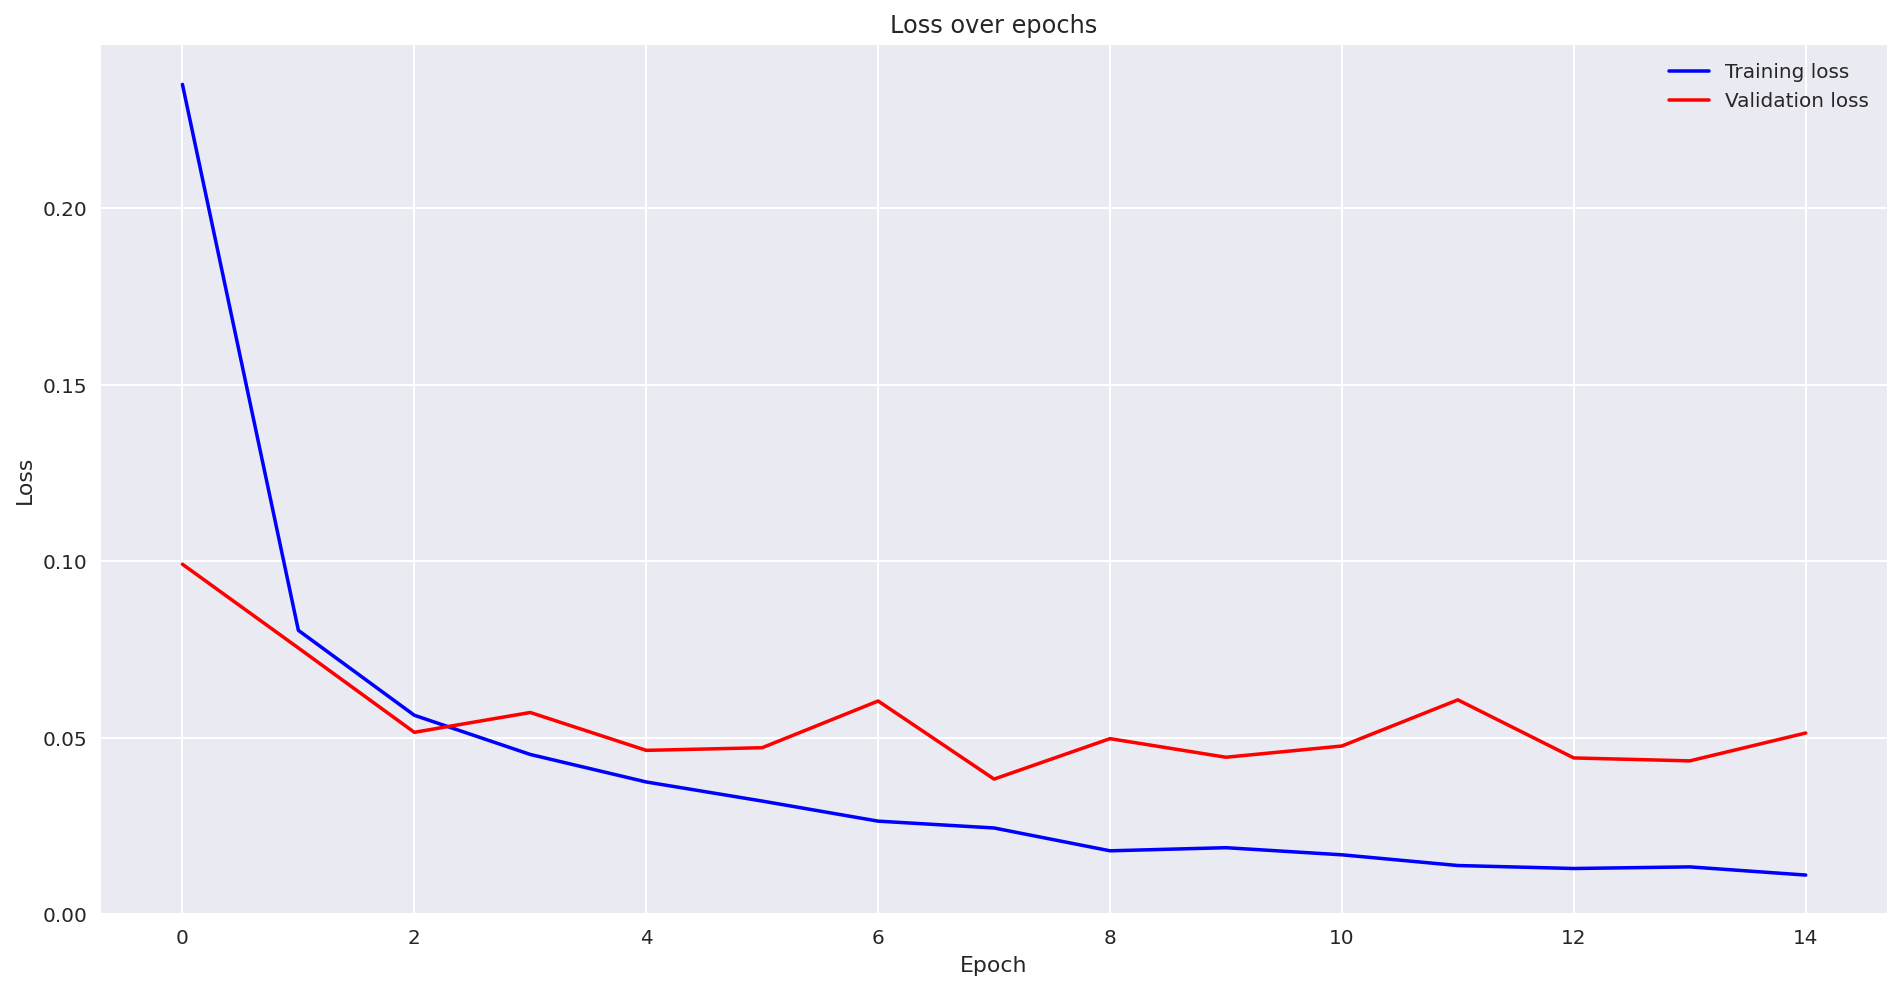

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

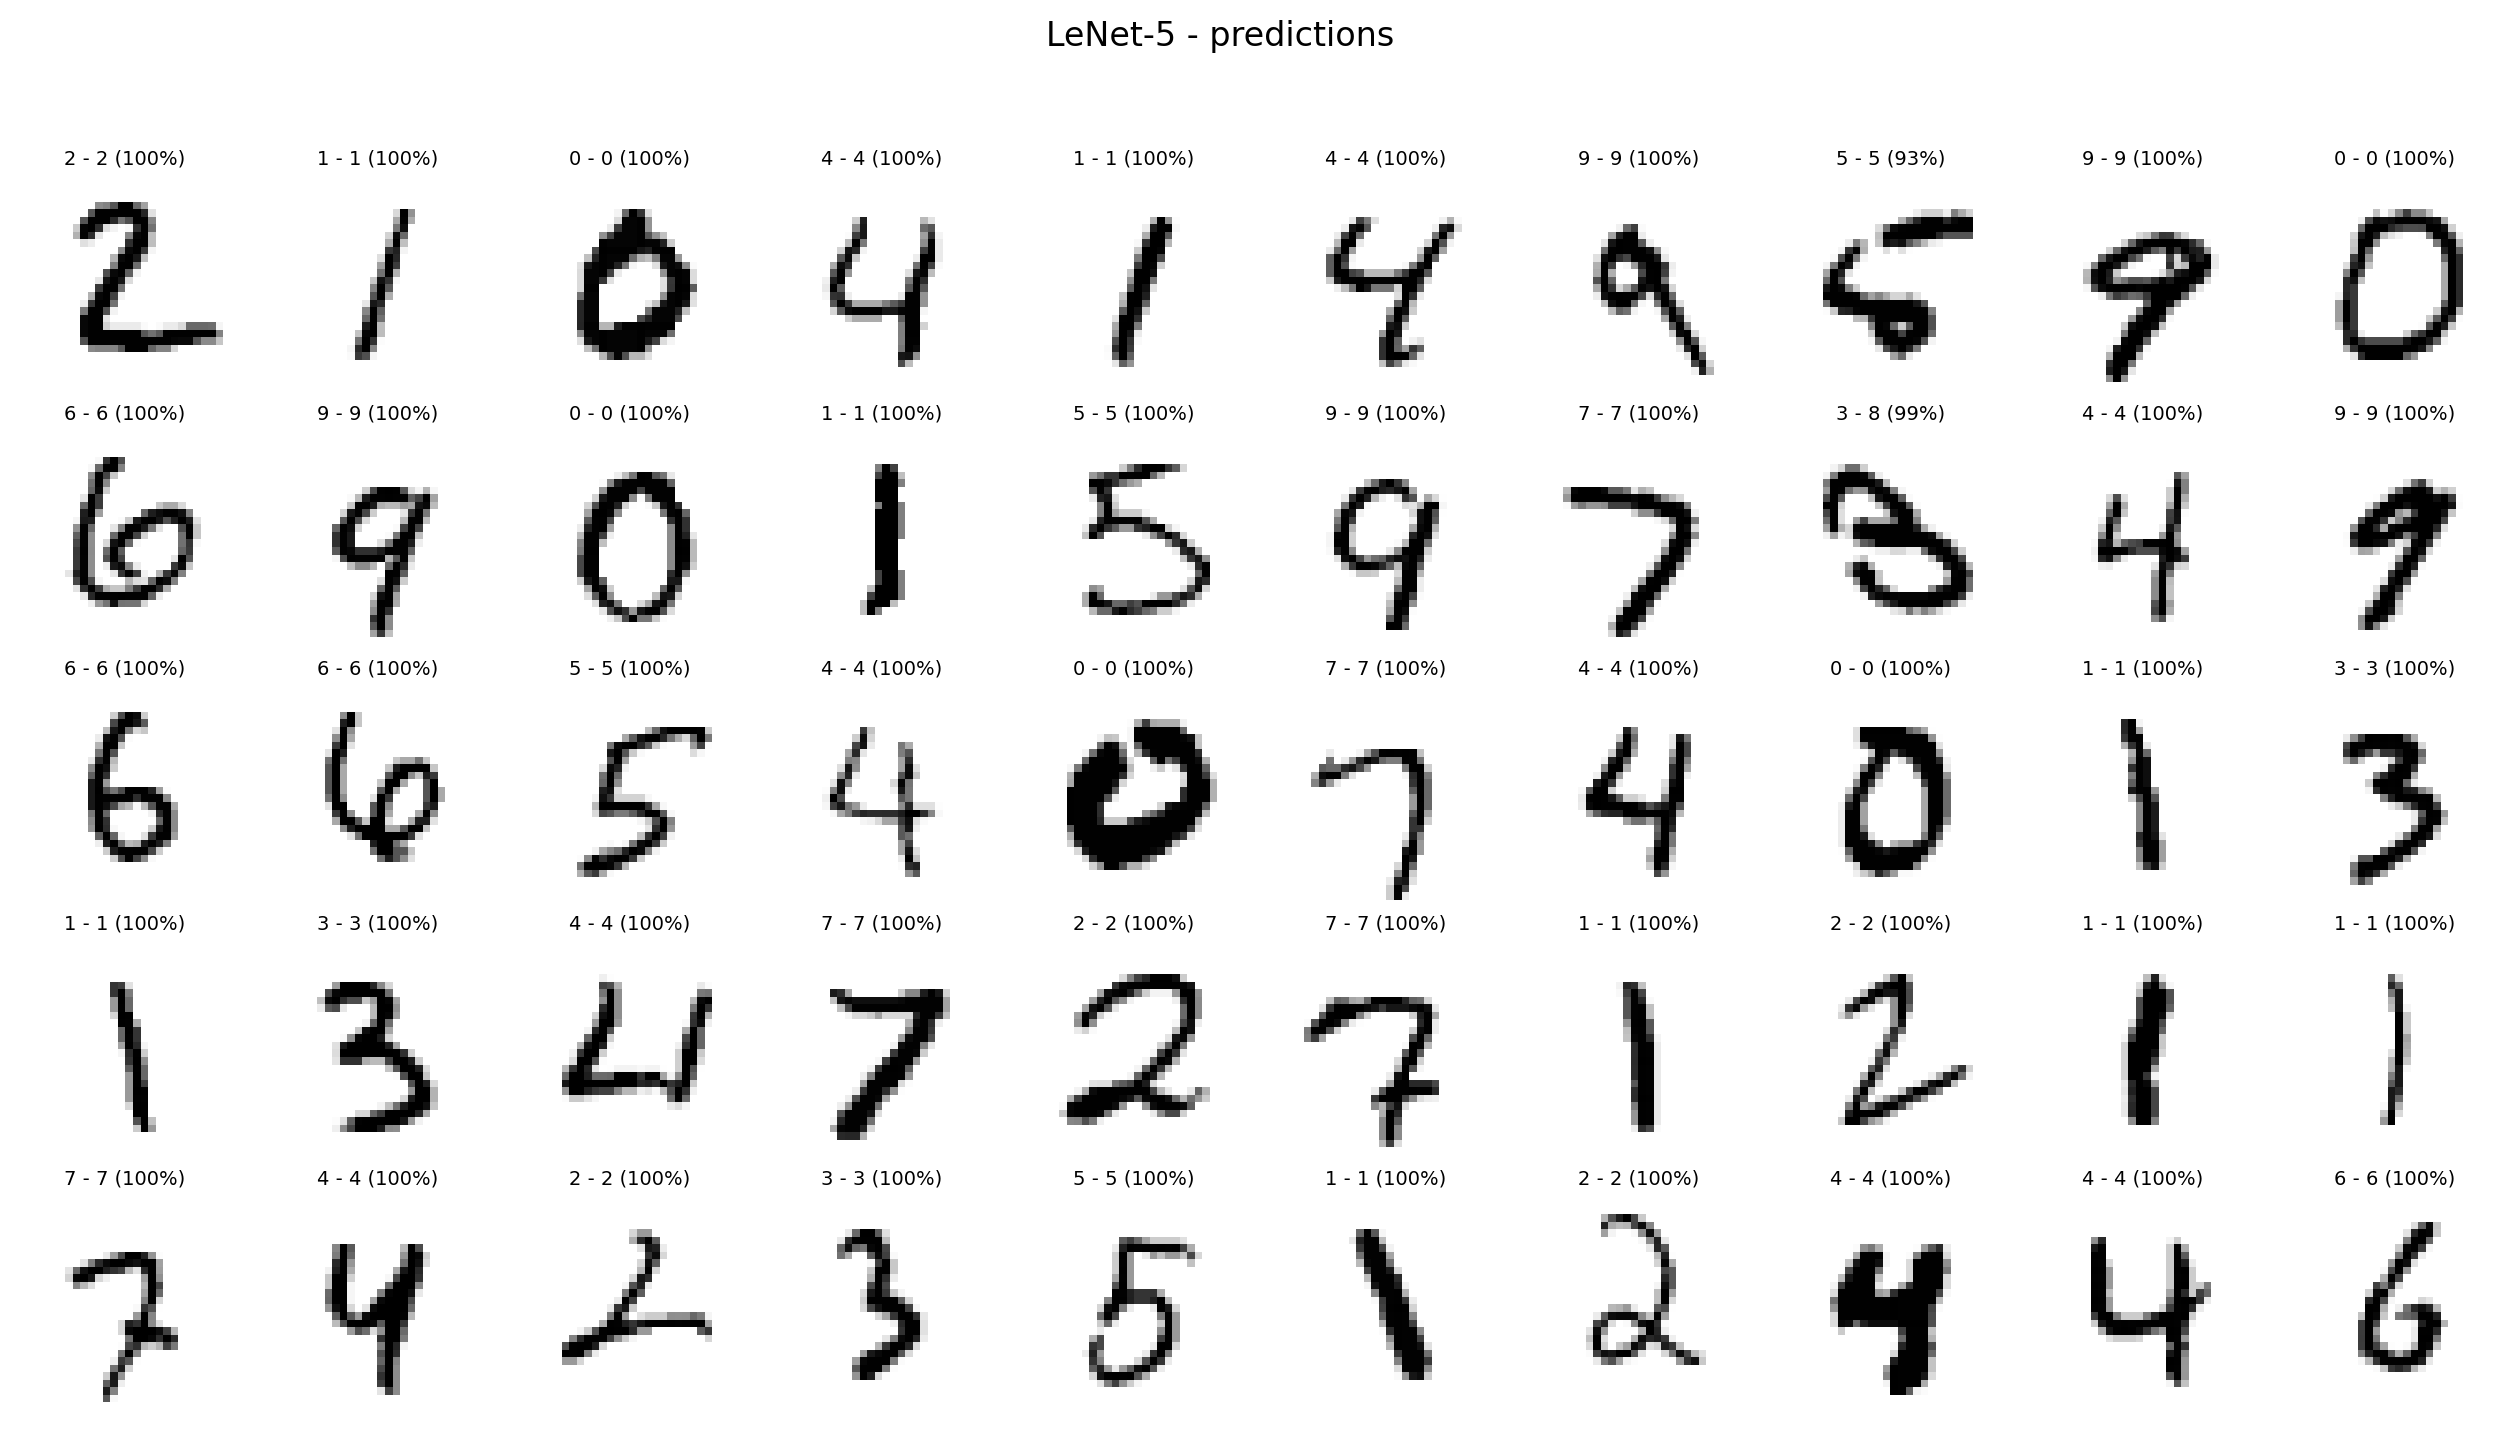

In [27]:
# return model to cpu if needed
model_cpu = model.to('cpu')
# plot predictions
fig = plt.figure(figsize=(16,8))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    # predict class with model on validation set
    with torch.no_grad():
        model.eval()
        _, probs = model_cpu(valid_dataset[index][0].unsqueeze(0))
    title = f'{valid_dataset.targets[index].item()} - {torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');